## IMPORTING LIBRARIES and Defining our directories where files are stored

In [22]:
import pandas as pd
import numpy as np
import os
np.random.seed(10)
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
import tensorflow as tf
from tensorflow import keras

In [24]:
train_dir = 'train/'
val_dir='validation/'
test_dir = 'test/'

In [25]:
row=48
col=48
classes = 7

## Preprocessing

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Dense, MaxPooling2D,Flatten,Dropout,Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger,TensorBoard,EarlyStopping,ReduceLROnPlateau
import datetime
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential

In [27]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                    zoom_range=0.1,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    horizontal_flip=True
                                    )


train_set=train_datagen.flow_from_directory(train_dir,
                                            batch_size=32,
                                            target_size=(48,48),
                                            shuffle=True,
                                            color_mode="grayscale",class_mode='categorical')


val_datagen = ImageDataGenerator(rescale=1./255)
val_set=val_datagen.flow_from_directory(val_dir,
                                            batch_size=32,
                                            target_size=(48,48),     
                                            color_mode="grayscale",class_mode='categorical')



test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                            batch_size=32,
                                            target_size=(48,48),
                                            shuffle=True,
                                            color_mode="grayscale",class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [28]:
train_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## MODEL-BUILDING

In [29]:
from keras.initializers import GlorotNormal
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D


In [30]:
#initalising the CNN model

def get_model(input_size, classes=7):
     #BUILDING the CNN.
    initializer = GlorotNormal()
    activation = Activation('relu')
    model = Sequential()
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = input_size, padding = 'same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(activation)

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(activation)
    model.add(MaxPooling2D((2, 2)))

    model.add(Dropout(0.5))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(activation)
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(activation)
    model.add(MaxPooling2D((2, 2)))


    model.add(Dropout(0.5))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(activation)
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(activation)
    model.add(MaxPooling2D((2, 2)))


    model.add(Dropout(0.5))
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(activation)
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(activation)
    model.add(MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(Dropout(0.5))
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(activation)

    model.add(Dense(7, activation='softmax'))
    
    #COMPLILING the CNN
    model.compile(optimizer= Adam(learning_rate=0.0001),#tf.keras.optimizers.SGD(lr=0.01,momentum=0.9, decay=0.0001, nesterov=True), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [31]:
our_model = get_model((48,48,1),classes)
our_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_9 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    multiple                  0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 64)       

In [32]:
# plot_model(our_model,to_file='Our Model Architecture.png',show_shapes=True,show_layer_names=True)

In [33]:
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
callbacks_list = [rlrop]

In [34]:

steps_per_epoch = train_set.n // 32
validation_steps = val_set.n // 32

mod = our_model.fit(x=train_set,
                        validation_data=val_set,
                        epochs=150,
                        shuffle=True,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        callbacks=[rlrop],
                        use_multiprocessing=True
                   )



Epoch 1/150
897/897 [==============================] - 41s 44ms/step - loss: 1.9190 - accuracy: 0.2247 - val_loss: 1.8477 - val_accuracy: 0.2257
Epoch 2/150
897/897 [==============================] - 39s 43ms/step - loss: 1.8314 - accuracy: 0.2454 - val_loss: 1.8187 - val_accuracy: 0.2556
Epoch 3/150
897/897 [==============================] - 39s 44ms/step - loss: 1.7806 - accuracy: 0.2723 - val_loss: 1.8109 - val_accuracy: 0.2966
Epoch 4/150
897/897 [==============================] - 39s 44ms/step - loss: 1.6818 - accuracy: 0.3330 - val_loss: 1.9965 - val_accuracy: 0.3156
Epoch 5/150
897/897 [==============================] - 39s 44ms/step - loss: 1.5694 - accuracy: 0.3903 - val_loss: 1.4728 - val_accuracy: 0.4222
Epoch 6/150
897/897 [==============================] - 38s 42ms/step - loss: 1.4921 - accuracy: 0.4251 - val_loss: 1.4334 - val_accuracy: 0.4461
Epoch 7/150
897/897 [==============================] - 39s 43ms/step - loss: 1.4400 - accuracy: 0.4501 - val_loss: 1.3750 - val_ac

In [35]:
# model_json=our_model.to_json()
# with open("model.json","w") as json_file:
#     json_file.write(model_json)

In [36]:
# our_model.save_weights('model_best_weights.h5')

### PERFORMANCE PLOT

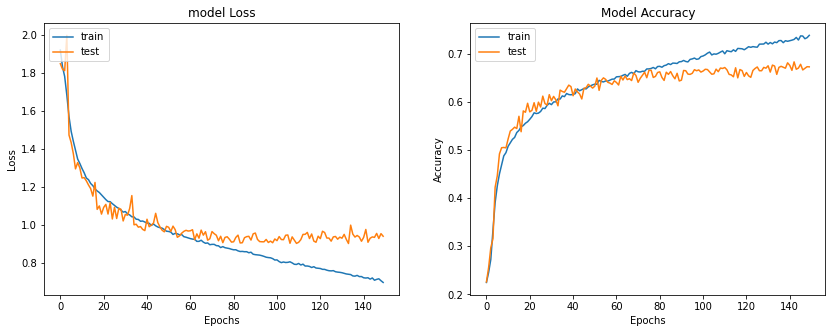

In [37]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(mod.history['accuracy'])
plt.plot(mod.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(mod.history['loss'])
plt.plot(mod.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
train_loss, train_accu = our_model.evaluate(train_set)
val_loss, val_accu = our_model.evaluate(val_set)
test_loss, test_accu = our_model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}, Test accuracy = {:.2f}".format(train_accu*100, val_accu*100, test_accu*100))

113/113 [==============================] - 7s 64ms/step - loss: 0.9022 - accuracy: 0.6955
final train accuracy = 80.12 , validation accuracy = 67.23, Test accuracy = 69.55


Confusion Matrix
[[ 224  165   50 1255  855 1130  316]
 [  22   18    3  143   95  118   37]
 [ 249  159   49 1271  861 1152  356]
 [ 406  287   91 2215 1524 2059  633]
 [ 252  220   56 1562 1131 1335  409]
 [ 273  205   53 1489 1036 1321  453]
 [ 184  112   26  986  712  897  254]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.06      0.08      3995
     disgust       0.02      0.04      0.02       436
        fear       0.15      0.01      0.02      4097
       happy       0.25      0.31      0.27      7215
     neutral       0.18      0.23      0.20      4965
         sad       0.16      0.27      0.21      4830
    surprise       0.10      0.08      0.09      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.13     28709
weighted avg       0.17      0.18      0.16     28709



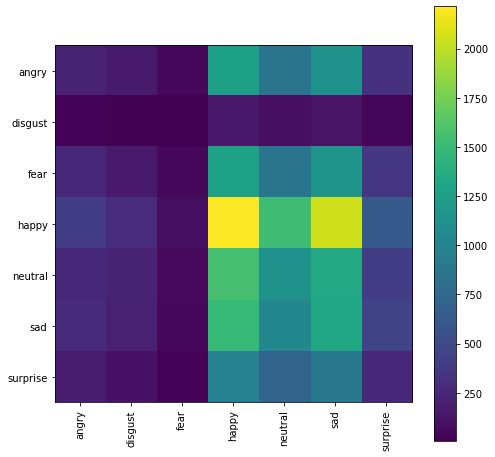

In [19]:
#ON TRAINING SET
y_pred = our_model.predict(train_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[ 42  27   8 140 159  69  46]
 [  4   4   0  17  13  16   1]
 [ 33  23   5 167 185  73  42]
 [ 83  35  14 227 298 137  85]
 [ 64  25  10 158 200  95  74]
 [ 51  31   8 173 194  81  56]
 [ 36  18   4 127 125  72  34]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.09      0.10       491
     disgust       0.02      0.07      0.04        55
        fear       0.10      0.01      0.02       528
       happy       0.22      0.26      0.24       879
     neutral       0.17      0.32      0.22       626
         sad       0.15      0.14      0.14       594
    surprise       0.10      0.08      0.09       416

    accuracy                           0.17      3589
   macro avg       0.13      0.14      0.12      3589
weighted avg       0.15      0.17      0.15      3589



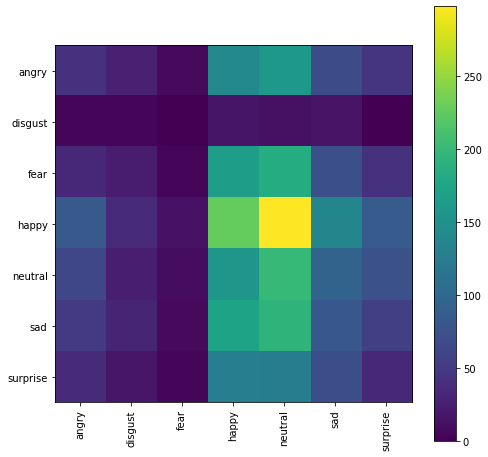

In [20]:
#ON TESTING SET
y_pred = our_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[ 39  13   7 135 151  68  54]
 [  2   4   2  13  23  12   0]
 [ 37  19   3 134 175  82  46]
 [ 73  41   6 251 277 140 107]
 [ 47  30   5 168 193  94  70]
 [ 63  27   7 174 212 113  57]
 [ 48  19   3 127 122  62  34]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.08      0.10       467
     disgust       0.03      0.07      0.04        56
        fear       0.09      0.01      0.01       496
       happy       0.25      0.28      0.26       895
     neutral       0.17      0.32      0.22       607
         sad       0.20      0.17      0.18       653
    surprise       0.09      0.08      0.09       415

    accuracy                           0.18      3589
   macro avg       0.14      0.14      0.13      3589
weighted avg       0.17      0.18      0.16      3589



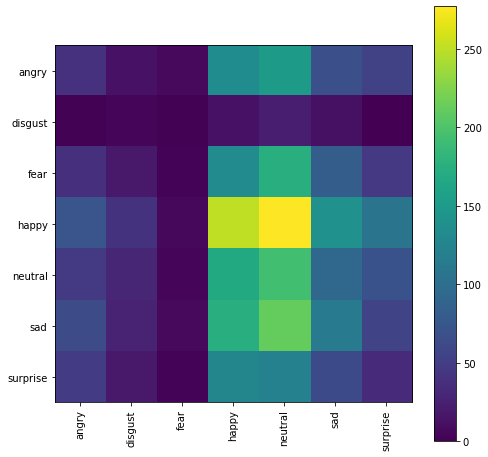

In [21]:
#ON Validation SET
y_pred = our_model.predict(val_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = val_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(val_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(val_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)